In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features=10000
max_len=500

Using TensorFlow backend.


In [4]:
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)
x_train=sequence.pad_sequences(x_train,maxlen=max_len)
x_test=sequence.pad_sequences(x_test,maxlen=max_len)

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Embedding(max_features,128,input_length=max_len))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

D:\anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 58s 3ms/step - loss: 0.8444 - acc: 0.5199 - val_loss: 0.6847 - val_acc: 0.5920
Epoch 2/10
20000/20000 [==============================] - 58s 3ms/step - loss: 0.6640 - acc: 0.6716 - val_loss: 0.6587 - val_acc: 0.6820
Epoch 3/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.6131 - acc: 0.7743 - val_loss: 0.5957 - val_acc: 0.7494
Epoch 4/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.5057 - acc: 0.8199 - val_loss: 0.4633 - val_acc: 0.8108
Epoch 5/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.3892 - acc: 0.8544 - val_loss: 0.4107 - val_acc: 0.8348
Epoch 6/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.3293 - acc: 0.8702 - val_loss: 0.4142 - val_acc: 0.8332
Epoch 7/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.2897 - acc: 0.8656 - val_loss: 0.3942 - val_acc:

In [14]:
import matplotlib.pyplot as plt

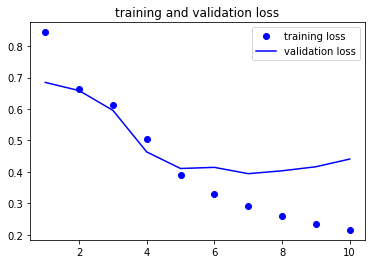

In [15]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [16]:
import os
data_dir=r'C:\Users\박정은\Downloads\006975\datasets\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [17]:
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

In [18]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [19]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [20]:
lookback=1440
step=6
delay=144
batch_size=128
train_gen=generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen=generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,shuffle=True,step=step,batch_size=batch_size)
test_gen=generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,shuffle=True,step=step,batch_size=batch_size)
val_steps=(300000-200001-lookback)//batch_size
test_steps=(len(float_data)-300001-lookback)//batch_size

In [21]:
model=Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae',metrics=['acc'])
histor=model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 50s 101ms/step - loss: 0.4131 - acc: 0.0000e+00 - val_loss: 0.4681 - val_acc: 0.0000e+00
Epoch 2/20
500/500 [==============================] - 44s 89ms/step - loss: 0.3609 - acc: 0.0000e+00 - val_loss: 0.4154 - val_acc: 0.0000e+00
Epoch 3/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3367 - acc: 0.0000e+00 - val_loss: 0.4190 - val_acc: 0.0000e+00
Epoch 4/20
500/500 [==============================] - 43s 86ms/step - loss: 0.3232 - acc: 0.0000e+00 - val_loss: 0.4369 - val_acc: 0.0000e+00
Epoch 5/20
500/500 [==============================] - 46s 93ms/step - loss: 0.3095 - acc: 0.0000e+00 - val_loss: 0.4571 - val_acc: 0.0000e+00
Epoch 6/20
500/500 [==============================] - 47s 93ms/step - loss: 0.3016 - acc: 0.0000e+00 - val_loss: 0.4957 - val_acc: 0.0000e+00
Epoch 7/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2916 - acc: 0.0000e+00 - val_loss: 0.4248 - val_acc: 0.0000e+00
Epoch

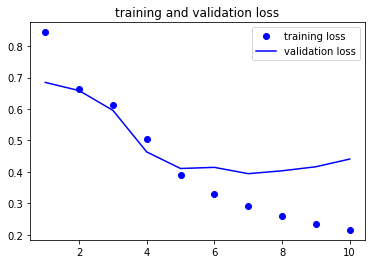

In [22]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()